In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import plotly.express as px

In [2]:
data_folder = '/home/sjkim/CMU/IDL/project/images/Data/real_data'
data_folder_left = data_folder + '/image_left/'
data_folder_right = data_folder + '/image_right/'

In [3]:
# real_data
image_dir = sorted(os.listdir(data_folder_left))
image_idx = [image[:-4] for image in image_dir]
print(image_idx)

['1666313493648', '1666313498715', '1666313501515', '1666313528981', '1666313529648']


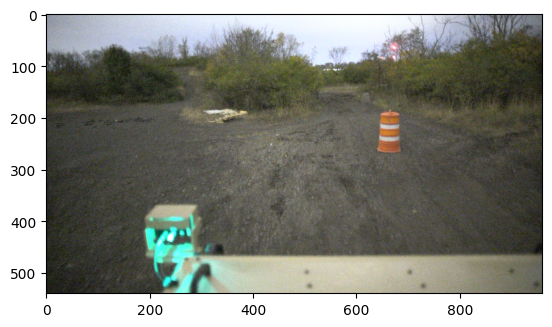

In [4]:
i=0 # first image
img_left_color = cv2.imread(data_folder_left + image_idx[i] + '.png')
img_right_color = cv2.imread(data_folder_right + image_idx[i] + '.png')
img_left_bw = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)
img_right_bw = cv2.cvtColor(img_right_color, cv2.COLOR_BGR2RGB)
plt.imshow(img_left_bw)

In [5]:
def showImg(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
def write_ply(fn, verts, colors):
    ply_header = '''ply
    format ascii 1.0
    element vertex %(vert_num)d
    property float x
    property float y
    property float z
    property uchar red
    property uchar green
    property uchar blue
    end_header
    '''
    out_colors = colors.copy()
    verts = verts.reshape(-1, 3)
    verts = np.hstack([verts, out_colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

Disparity map

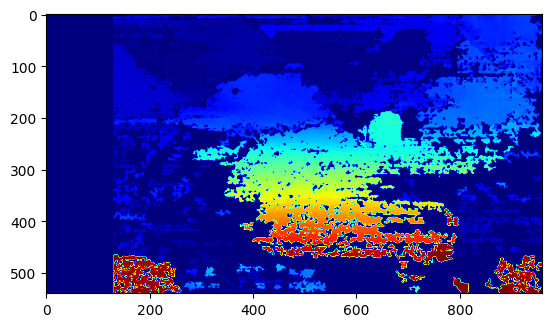

In [6]:
uniquenessRatio = 6
num_disp = 128
specklewindow = 100
stereo = cv2.StereoSGBM_create(minDisparity = 2,
                 numDisparities = num_disp,
                 blockSize = 5,
                 uniquenessRatio = uniquenessRatio,
                 speckleWindowSize = specklewindow,
                 speckleRange = 3,
                 disp12MaxDiff = 2,
                 P1 = 13 *13*3*3,
                 P2 = 4 * 13 * 13*3*3)

disparity = stereo.compute(img_left_bw,img_right_bw)

img = disparity.copy()
plt.imshow(img, 'jet')

load intrinsics

In [8]:
# camera matrix
calib_matrix_1 = "643.7421089647805 0.0 479.5 0.0 641.7043546064523 269.5 0.0 0.0 1.0" 
calib_matrix_1 = np.array(calib_matrix_1.strip().split(" ")).astype('float32').reshape(3,-1)
print(calib_matrix_1)

calib_matrix_2 = "640.6533607062842 0.0 479.5 0.0 639.0720372559647 269.5 0.0 0.0 1.0"
calib_matrix_2 = np.array(calib_matrix_2.strip().split(" ")).astype('float32').reshape(3,-1)
print(calib_matrix_2)

cam1 = calib_matrix_1
cam2 = calib_matrix_2

[[643.7421    0.      479.5    ]
 [  0.      641.70435 269.5    ]
 [  0.        0.        1.     ]]
[[640.6534   0.     479.5   ]
 [  0.     639.072  269.5   ]
 [  0.       0.       1.    ]]


In [9]:
# distortion coefficients
distCoeffs1 = "-0.06024218530052934 0.05487975399353512 0.0 0.0 0.0"
distCoeffs1 = np.array(distCoeffs1.strip().split(" ")).astype('float32')
print(distCoeffs1)
distCoeffs2 = "-0.058277712397492305 0.04527613807646963 0.0 0.0 0.0"
distCoeffs2 = np.array(distCoeffs2.strip().split(" ")).astype('float32')
print(distCoeffs2)

[-0.06024218  0.05487975  0.          0.          0.        ]
[-0.05827771  0.04527614  0.          0.          0.        ]


In [10]:
# calculate projection matrix
Tmat = np.array([-0.54, 0., 0.])

rev_proj_matrix = np.zeros((4,4))

cv2.stereoRectify(cameraMatrix1 = calib_matrix_1,cameraMatrix2 = calib_matrix_2, \
                  distCoeffs1 = distCoeffs1, distCoeffs2 = distCoeffs2, \
                  imageSize = img_left_color.shape[:2], \
                  R = np.identity(3), T = Tmat, \
                  R1 = None, R2 = None, \
                  P1 =  None, P2 =  None, Q = rev_proj_matrix);
print(rev_proj_matrix)                  


[[   1.            0.            0.         -476.81667757]
 [   0.            1.            0.         -276.71245575]
 [   0.            0.            0.          640.38818359]
 [   0.            0.            1.85185185   -0.        ]]


In [12]:
points = cv2.reprojectImageTo3D(img, rev_proj_matrix)

#reflect on x axis
reflect_matrix = np.identity(3)
reflect_matrix[0] *= -1
points = np.matmul(points,reflect_matrix)

#extract colors from image
colors = cv2.cvtColor(img_left_color, cv2.COLOR_BGR2RGB)

#filter by min disparity
mask = img > img.min()
out_points = points[mask]
out_colors = colors[mask]

#filter by dimension
# idx = np.fabs(out_points[:,0]) < 4.5
# out_points = out_points[idx]
# out_colors = out_colors.reshape(-1, 3)
# out_colors = out_colors[idx]

write_ply('out_realdata.ply', out_points, out_colors)
print('%s saved' % 'out_realdata.ply')

out_realdata.ply saved


In [13]:
# make html file
fig = px.scatter_3d(x=out_points[:, 0], y=out_points[:, 1], z=out_points[:, 2])
fig.update_traces(marker={'size': 1, "color": [f'rgb({x[0]}, {x[1]}, {x[2]})' for x in out_colors]})
fig.write_html("/home/sjkim/CMU/IDL/project/PointCloud/point_cloud_new.html")

In [14]:
reflected_pts = np.matmul(out_points, reflect_matrix)
projected_img,_ = cv2.projectPoints(reflected_pts, np.identity(3), np.array([0., 0., 0.]), \
                          cam2[:3,:3], np.array([0., 0., 0., 0.]))
projected_img = projected_img.reshape(-1, 2)

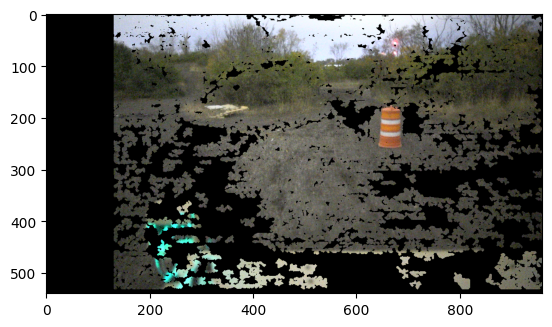

In [15]:
blank_img = np.zeros(img_left_color.shape, 'uint8')
# img_colors = img_right_color[mask][idx].reshape(-1,3)
img_colors = img_left_color[mask].reshape(-1,3)

for i, pt in enumerate(projected_img):
    pt_x = int(pt[0])
    pt_y = int(pt[1])
    if pt_x > 0 and pt_y > 0:
        # use the BGR format to match the original image type
        # col = (int(img_colors[i, 2]), int(img_colors[i, 1]), int(img_colors[i, 0]))
        col = (int(img_colors[i, 0]), int(img_colors[i, 1]), int(img_colors[i, 2]))
        cv2.circle(blank_img, (pt_x, pt_y), 1, col)
showImg(blank_img)        